In [1]:
import os
import glob
import numpy as np
import filament
import datetime
import cmocean
import logging
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
from importlib import reload

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


## Files and directories

In [2]:
sstfile = "/data/SST/CapeGhir/V20181722018263.L3m_SNSU_SNPP_NSST_sst_4km.nc"
sstfile2 = "/data/SST/CapeGhir/T20001732018263.L3m_SCSU_NSST_sst_4km.nc"
datafileu = "/data/Wind/SCOW/wind_stress_zonal_monthly_maps.nc"
datafilev = "/data/Wind/SCOW/wind_stress_meridional_monthly_maps.nc"

In [3]:
def load_SST_L3(datafile, coordinates=None):
    with netCDF4.Dataset(datafile, "r") as nc:
        lon = nc.variables["lon"][:]
        lat = nc.variables["lat"][:]
        sstvar = nc.get_variables_by_attributes(standard_name="sea_surface_temperature")[0]
        if coordinates is not None:
            goodlon = np.where( (lon<= coordinates[1]) & (lon>= coordinates[0]))[0]
            goodlat = np.where( (lat<= coordinates[3]) & (lat>= coordinates[2]))[0]
            lon = lon[goodlon]
            lat = lat[goodlat]
            sst = sstvar[goodlat, goodlon]
        else:
            sst = sstvar[:,:]
    return lon, lat, sst

In [4]:
def get_wind_stress(datafile, coordinates=None):
    with netCDF4.Dataset(datafile, "r") as nc:
        lat = nc.variables["latitude"][:]
        lon = nc.variables["longitude"][:]
        lon[lon>180.] = lon[lon>180.] - 360.
        
        if coordinates is not None:
            goodlon = np.where( (lon<= coordinates[1]) & (lon>= coordinates[0]))[0]
            goodlat = np.where( (lat<= coordinates[3]) & (lat>= coordinates[2]))[0]
            lon = lon[goodlon]
            lat = lat[goodlat]
        windstress = np.empty((len(lat), len(lon), 12))
        windstress_vars = nc.get_variables_by_attributes(units="N/m^2")
        for i in range(0, 12):
            if coordinates is not None:
                windstress[:,:,i] = windstress_vars[i][goodlat, goodlon]
            else:
                windstress[:,:,i] = windstress_vars[i][:, :]
        windstress = np.ma.masked_where(windstress==-9999.0, windstress)
    return lon, lat, windstress

In [11]:
m1 = Basemap(projection='ortho',lon_0=-20., lat_0=0, resolution='c')
m2 = Basemap(projection='ortho',lon_0=-100.,lat_0=0, resolution='c')
m3 = Basemap(projection='kav7',lon_0=0,resolution='c')

In [6]:
coordinatesSST = (-150., 45., -80., 80.)
lonsst1, latsst1, sst1 = load_SST_L3(sstfile)
coordinatesSST = (-180., 0., -80., 80.)
lonsst2, latsst2, sst2 = load_SST_L3(sstfile2)

In [7]:
llon, llat = np.meshgrid(lonsst1, latsst1)
lonp1, latp1 = m1(llon, llat)
lonp1[lonp1==lonp1.max()] = np.nan
latp1[latp1==latp1.max()] = np.nan

llon, llat = np.meshgrid(lonsst2, latsst2)
lonp2, latp2 = m2(llon, llat)
lonp2[lonp2==lonp2.max()] = np.nan
latp2[latp2==latp2.max()] = np.nan

In [8]:
ebuscoordinates = [(-30., -5., 15., 35.),
                   (-138., -115., 30., 45.),
                   (-85., -70., -35., -15.),
                   (6., 20., -35., -15.)
                  ]

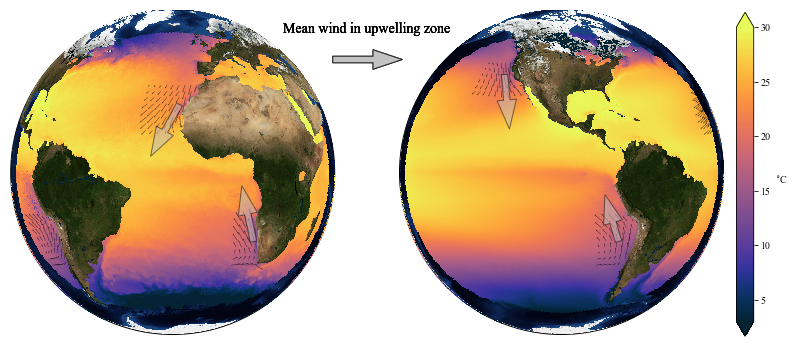

In [9]:
NN = 1
Nw = 10
fig = plt.figure(figsize=(12, 10))

ax = plt.subplot(1,2,1)
m1.pcolormesh(lonp1[::NN], latp1[::NN], sst1[::NN], cmap=cmocean.cm.thermal,
             zorder=3, vmin=3., vmax=30.)
m1.warpimage("world.topo.bathy.200403.3x5400x2700.jpg", zorder=2)

# m.fillcontinents(color='grey')
#plt.colorbar(extend="both", shrink=.7)

# Add wind
i = 0
for coords in ebuscoordinates:
    lon, lat, ustress = get_wind_stress(datafileu, coords)
    lon, lat, vstress = get_wind_stress(datafilev, coords)
    llon, llat = np.meshgrid(lon, lat)
    lonp, latp = m1(llon, llat)
    
    if (i == 0) | (i == 3):
        lonc = np.mean(lon)
        latc = np.mean(lat)
        lonc2, latc2 = m1(lonc, latc)
        umean = np.mean(ustress[:,:,6:8])
        vmean = np.mean(vstress[:,:,6:8])
        quiv = m1.quiver(lonc2, latc2, umean, vmean, scale=.35, width=.02,  
                  alpha=.5, zorder=5, headwidth=3, headlength=4.5,
                  edgecolor="k", facecolors=".75", linewidth=1)
        
    qk = plt.quiverkey(quiv, 1.1, 0.85, 0.075, "Mean wind in upwelling zone\n ", labelpos='N',
                       fontproperties={"size":14, "family": "times new roman"})
    
    m1.quiver(lonp[::Nw,::Nw], latp[::Nw,::Nw], 
             np.nanmean(ustress[:,:,6:8], axis=2)[::Nw,::Nw], 
             np.nanmean(vstress[:,:,6:8], axis=2)[::Nw,::Nw], scale=3, width=.001, zorder=4)
    
    i += 1
    
ax = plt.subplot(1,2,2)
m2.ax = ax
pcm = m2.pcolormesh(lonp2[::NN], latp2[::NN], sst2[::NN], cmap=cmocean.cm.thermal,
             zorder=3, vmin=3., vmax=30.)
# m.fillcontinents(color='grey')
m2.warpimage("world.topo.bathy.200403.3x5400x2700.jpg", zorder=2)


# Add wind
i = 0
for coords in ebuscoordinates:
    lon, lat, ustress = get_wind_stress(datafileu, coords)
    lon, lat, vstress = get_wind_stress(datafilev, coords)
    llon, llat = np.meshgrid(lon, lat)
    lonp, latp = m2(llon, llat)
    
    if (i == 1) | (i == 2):
        lonc = np.mean(lon)
        latc = np.mean(lat)
        lonc2, latc2 = m2(lonc, latc)
        umean = np.mean(ustress[:,:,6:8])
        vmean = np.mean(vstress[:,:,6:8])
        m2.quiver(lonc2, latc2, umean, vmean, scale=.35, width=.02,  
                  alpha=.5, zorder=5, headwidth=3, headlength=4.5,
                  edgecolor="k", facecolors=".75", linewidth=1)
        
    m2.quiver(lonp[::Nw,::Nw], latp[::Nw,::Nw], 
             np.nanmean(ustress[:,:,6:8], axis=2)[::Nw,::Nw], 
             np.nanmean(vstress[:,:,6:8], axis=2)[::Nw,::Nw], scale=3, width=.001, zorder=4)
    
    i += 1
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.965, 0.275, 0.02, 0.45])
cb = plt.colorbar(pcm, cax=cbar_ax, extend="both")
cb.set_label("$^{\circ}$C", rotation=0, ha="left")
plt.savefig("SST_wind_summer_2018_07", dpi=300, bbox_inches="tight")
#plt.show()
plt.close()

## Single map with global projection

In [18]:
llon, llat = np.meshgrid(lonsst1, latsst1)
lonp3, latp3 = m3(llon, llat)
lonp3[lonp3==lonp3.max()] = np.nan
latp3[latp3==latp3.max()] = np.nan

In [56]:
NN = 1
Nw = 10
fig = plt.figure(figsize=(12, 10))

pcm = m3.pcolormesh(lonp3[::NN], latp3[::NN], sst1[::NN], cmap=cmocean.cm.thermal,
             zorder=3, vmin=3., vmax=30.)
m3.warpimage("world.topo.bathy.200403.3x5400x2700.jpg", zorder=2)

i = 0
for coords in ebuscoordinates:
    lon, lat, ustress = get_wind_stress(datafileu, coords)
    lon, lat, vstress = get_wind_stress(datafilev, coords)
    llon, llat = np.meshgrid(lon, lat)
    lonp, latp = m3(llon, llat)
    
   
    lonc = np.mean(lon)
    latc = np.mean(lat)
    lonc2, latc2 = m3(lonc, latc)
    umean = np.mean(ustress[:,:,6:8])
    vmean = np.mean(vstress[:,:,6:8])
    quiv = m3.quiver(lonc2, latc2, umean, vmean, scale=.6, width=.012,  
              alpha=.5, zorder=5, headwidth=1.75, headlength=4.5,
              edgecolor="k", facecolors=".75", linewidth=1)
    """x
    if i == 0:
        qk = plt.quiverkey(quiv, .1, .1, 0.075, "Mean wind in upwelling zone\n ", 
                           labelpos='N',
                           fontproperties={"size":14, "family": "times new roman"})
    """
    
    m3.quiver(lonp[::Nw,::Nw], latp[::Nw,::Nw], 
             np.nanmean(ustress[:,:,6:8], axis=2)[::Nw,::Nw], 
             np.nanmean(vstress[:,:,6:8], axis=2)[::Nw,::Nw], scale=3, width=.001, zorder=4)
    
    i += 1
    
cb = plt.colorbar(pcm, extend="both", shrink=.55)
cb.set_label("$^{\circ}$C", rotation=0, ha="left")
plt.savefig("SST_wind_summer_2018_08", dpi=300, bbox_inches="tight")
#plt.show()
plt.close()